In [183]:
##### Prérequis #####
#from platform import python_version
#print(python_version())
#!pip install plotly==5.7.0
#!pip install plotly
#!pip install wordcloud
#Installer le python 3.8 comme prérequis pour la librairie snscraping
#!pip install textblob
!pip install -U textblob

!python -m textblob.download_corpora

zsh:1: command not found: python


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import plotly.express as px
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from platform import python_version
#from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahsamaali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1- Extraction des données et prétraitement de la série temporelle: 

In [72]:
#https://github.com/datasets/oil-prices
#s'assurer que le fichier est dans le meme dossier pour ne pas modifier le chemin
data=pd.read_excel("/Users/mahsamaali/Documents/polymtl/Hiver2022/Valorisation des Données/Projet-Analysis/RBRTEd.xls") 
data.head()

,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [73]:
#changer le nom de la colonne
data = data.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'})
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8840 entries, 0 to 8839
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8840 non-null   datetime64[ns]
 1   Price   8840 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 138.2 KB


In [75]:
#Convertir les variables
data["Date"]= pd.to_datetime(data["Date"], format='%Y-%m-%d')
data["Price"]=pd.to_numeric(data["Price"])
start_date = "2006-03-21" #Date de création de Twitter
data=data[data["Date"]>=start_date]
data.set_index('Date',inplace=True)
data.head()

,Price
Date,
2006-03-21,59.96
2006-03-22,61.23
2006-03-23,61.76
2006-03-24,62.78
2006-03-27,62.59


### 1.2- Analyse et comparaison (choix de la série et de la date d'analyse): 

In [76]:
#aggréagation des données par mois en utilisant la moyenne
data_monthly=data.resample("M").mean()

<ipython-input-77-eb474b8390c5>:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



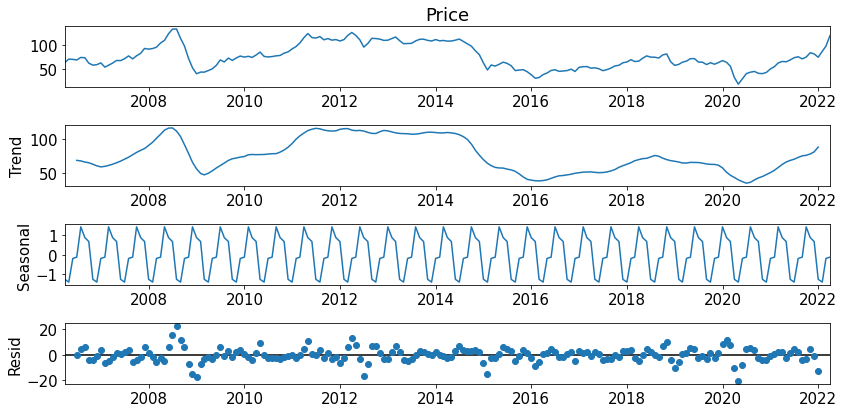

In [77]:
#Vu que la série est tres volatile dans le temps, nous optons à la décomposer afin d'extraire les valeurs extrémums
# et avoir moins de volatilité entre le min et le max de la série
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
result = seasonal_decompose(data_monthly.Price,model="additive",freq=7)
result.plot()
plt.show()

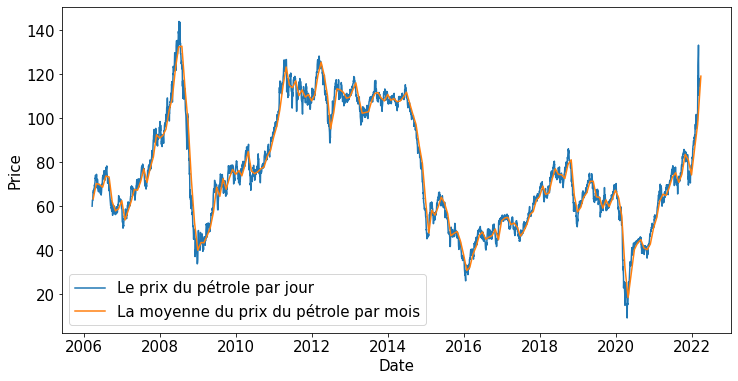

In [78]:
#Nous remarquons que la moyenne est calqué sur les données brutes de la série, 
#d'autre part, ça permet de garder l'exatitude des dates par rapport aux données brutes
sns.lineplot(x=data.index,y=data.Price,label='Le prix du pétrole par jour')
sns.lineplot(x=data_monthly.index,y=data_monthly.Price, label='La moyenne du prix du pétrole par mois')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Date', ylabel='Price'>

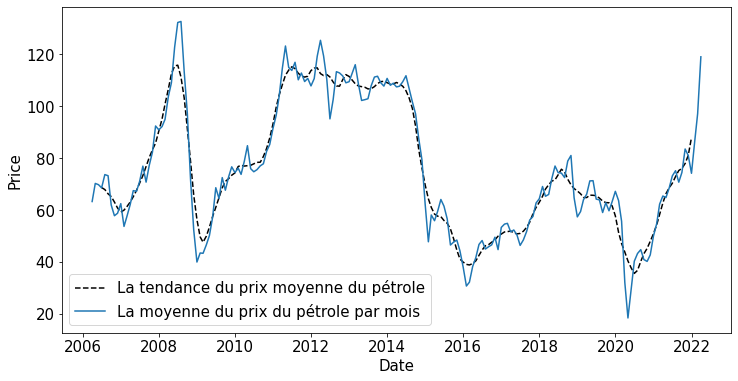

In [79]:
# Nous remarquons que la décomposition nous offre un lissage et moins de variations au niveau de la série
# Cependant, il existe un déclage temporel entre la série de la moyenne et la tendance de la série
# Par conséquent, l'utilisation de la tendance necessite une extraction temporelle décaler 
# Autrement dit, nous allons effectuer une extraction décaler de 2 à 3 mois afin d'avoir le maximum
# d'information avant la date des extremums (min ou max local de la série)
x = result.trend.index
y = result.trend.values
sns.lineplot(x, y, color='black',linestyle='--', label='La tendance du prix moyenne du pétrole')
sns.lineplot(x=data_monthly.index,y=data_monthly.Price, label='La moyenne du prix du pétrole par mois')

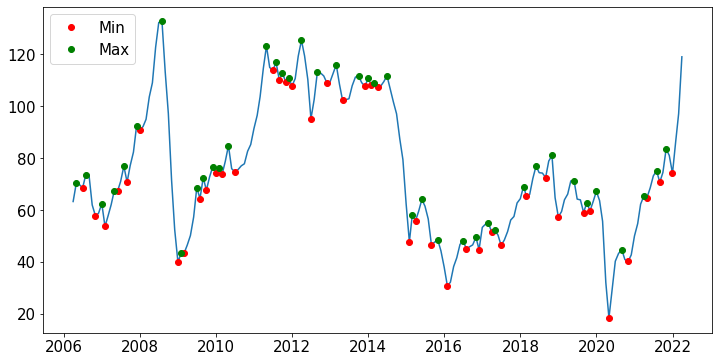

Nombre des extremums maximums: 41
Nombre des extremums minimums: 41


In [80]:
x = data_monthly.index
y = data_monthly.Price
a = np.diff(np.sign(np.diff(y))).nonzero()[0] + 1 
b = (np.diff(np.sign(np.diff(y))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(y))) < 0).nonzero()[0] + 1         # local max
plt.plot(x, y)
plt.plot(x[b], y[b], "o", label="Min", color='r')
plt.plot(x[c], y[c], "o", label="Max", color='g')
plt.legend()
plt.show()
print ('Nombre des extremums maximums:', len(b))
print ('Nombre des extremums minimums:', len(c))

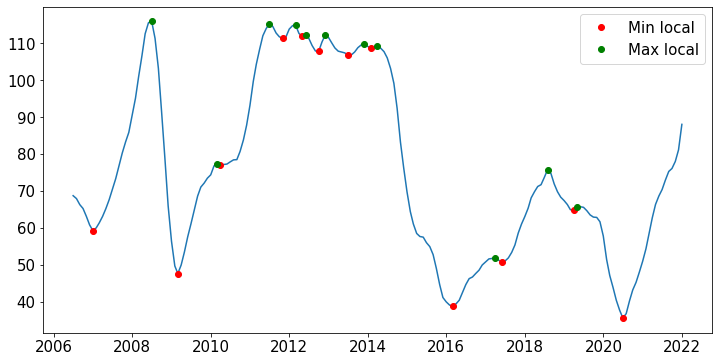

Nombre des extremums maximums: 12
Nombre des extremums minimums: 11


In [81]:
x = result.trend.index
y = result.trend.values
a = np.diff(np.sign(np.diff(y))).nonzero()[0] + 1 
b = (np.diff(np.sign(np.diff(y))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(y))) < 0).nonzero()[0] + 1         # local max
plt.plot(x, y)
plt.plot(x[b], y[b], "o", label="Min local", color='r')
plt.plot(x[c], y[c], "o", label="Max local", color='g')
plt.legend()
plt.show()
print ('Nombre des extremums maximums:', len(b))
print ('Nombre des extremums minimums:', len(c))

In [82]:
x[b],y[b]

(DatetimeIndex(['2006-12-31', '2009-02-28', '2010-03-31', '2011-10-31',
                '2012-04-30', '2012-09-30', '2013-06-30', '2014-01-31',
                '2016-02-29', '2017-05-31', '2019-03-31', '2020-06-30'],
               dtype='datetime64[ns]', name='Date', freq=None),
 array([ 59.18398496,  47.5983637 ,  76.96103668, 111.27163575,
        111.85627582, 107.75107113, 106.71577922, 108.55423321,
         38.81289177,  50.80630685,  64.80607578,  35.56047836]))

In [83]:
# Nous remarquons qu'ils existent plus d'extremums au niveau de la série de la moyenne (data_monthly) 
# par rapport à la série de la tendance 
# Nous allons choisir les extremums les plus significatifs, qui se trouvent sur la série de la tendance

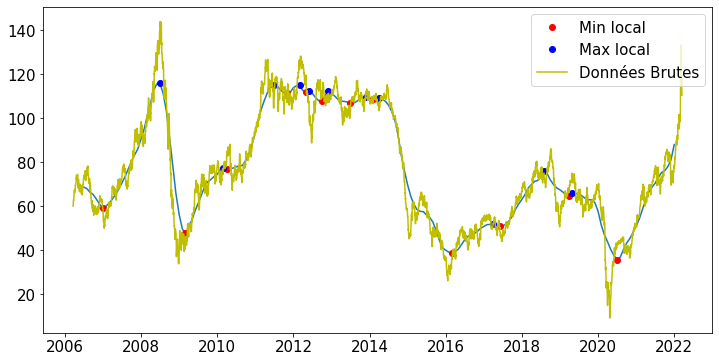

In [84]:
plt.plot(x, y)
plt.plot(x[b], y[b], "o", label="Min local", color='r')
plt.plot(x[c], y[c], "o", label="Max local", color='b')
plt.plot(data.index,data.Price,"-",label="Données Brutes",color='y')
plt.legend()
plt.show()

In [85]:
# Nous allons choisir le troisieme maximum de la série qui est :
x[c][2],y[c][2]

(Timestamp('2011-06-30 00:00:00'), 115.25020736647755)

### 1.3- Seléction de la durée d'analyse : 

In [86]:
# Nou exposons la série des données brutes entre 01-01-2010 et le 31-12-2011
X=data[(data.index>="01-01-2010") & (data.index<= "31-12-2011")]

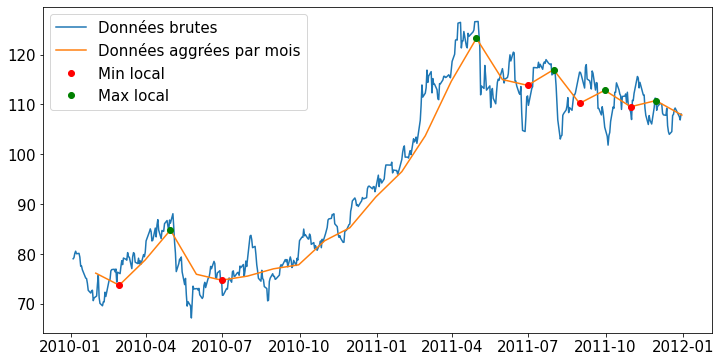

In [87]:
plt.plot(X, label="Données brutes")
M=X.resample("M").mean()
x=M.index
y=M.Price
a = np.diff(np.sign(np.diff(y))).nonzero()[0] + 1 
b = (np.diff(np.sign(np.diff(y))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(y))) < 0).nonzero()[0] + 1         # local max
plt.plot(x, y, label="Données aggrées par mois")  #Nous avons utiliser la moyenne pour aggréger les données
plt.plot(x[b], y[b], "o", label="Min local", color='r')
plt.plot(x[c], y[c], "o", label="Max local", color='g')
plt.legend()
plt.show()

In [88]:
#Extremums Min
y[b]

Date
2010-02-28     73.752105
2010-06-30     74.760909
2011-06-30    113.833182
2011-08-31    110.219545
2011-10-31    109.550000
Name: Price, dtype: float64

In [89]:
#Extremums Max
y[c]

Date
2010-04-30     84.817619
2011-04-30    123.258889
2011-07-31    116.973500
2011-09-30    112.833810
2011-11-30    110.768095
Name: Price, dtype: float64

In [90]:
# Remarquons que selon les données brutes, le prix du pétrole a connu une forte baisse 
# en 25-05-2010 (67.18$). Cependant, la forte baisse se manifeste sur la série aggrégée par mois qu'a
# partir du 2010-06-30 (74.760909$). Un déclage de 66 jours
X[X.Price==X.Price.min()]

,Price
Date,
2010-05-25,67.18


In [91]:
#Aussi pour le max, sur la série de tenadance, le max est atteint 2011-04-30 (123.258889). 
# Par contre, le max sur la série des données brutes est atteint 2011-05-02(126.64)
# Un déclage de 2 jours 
X[X.Price==X.Price.max()]

,Price
Date,
2011-05-02,126.64


In [92]:
# Afin d'avoir plus de fiablité sur les données, on se concentre d'extraire les données entre 2011-05-02 et 2011-02-02
Données_input=data[(data.index>="2011-02-02") & (data.index<= "2011-05-02")]

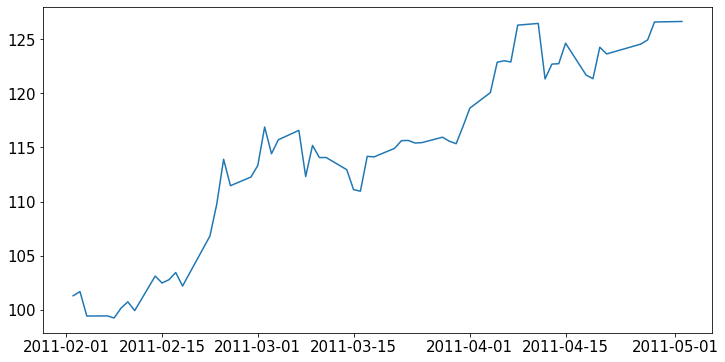

In [93]:
plt.plot(Données_input)

In [94]:
#Soit des données de 60 jours 
Données_input.shape

(60, 1)

In [95]:
import plotly.express as px
df=Données_input
fig = px.line(df, x=df.index, y="Price")

fig.show()

### 2- Analyse des tweets : 

#### 2.1- Extraction des tweets entre 2011-05-02 et 2011-02-02 :

In [96]:
### Pour réaliser l'extraction avec le SNS la vérsion de python doit etre >=3.8
print(python_version())

3.8.5


#### 2.2- Prétraitement des tweets :

In [ ]:
def get_data(since_date,until_date):

	text_query = "#oilprice OR #CrudeOil OR #fuelprices OR #oil OR #OOTT OR #opec OR #oilbusiness"


	# Using OS library to call CLI commands in Python
	os.system(
		'snscrape --jsonl  --since {} twitter-search "{} until:{}" > assets/dataOil.json'.format(since_date,
		                                                                                                  text_query,
		                                                                                                  until_date))
	file_csv='assets/{}.csv'.format(until_date)

	tweets_df1 = pd.read_json('assets/dataOil.json', lines=True)


In [ ]:
since_date = "2011-04-01"
until_date = "2011-05-03"
#getTweets base on the date
df=data_collection.get_data(nb_tweets,since_date,until_date)

In [97]:
file_location='/Users/mahsamaali/data - data1.csv'
tweets=pd.read_csv(file_location) 
tweets.head()

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,retweetedTweet,quotedTweet,inReplyToTweetId,hashtags,cashtags
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,['Oil'],NaN
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,"['crude', 'oil', 'risk']",NaN
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,"['Oil', 'BRK']",NaN
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,"['Forex', 'finance', 'stocks', 'currency', 'go...",NaN
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,NaN,NaN,NaN,['oil'],NaN


In [98]:
tweets.shape

(27391, 12)

In [99]:
tweets.columns

Index(['date', 'content', 'user', 'replyCount', 'retweetCount', 'likeCount',
       'quoteCount', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'hashtags', 'cashtags'],
      dtype='object')

In [100]:
#nous remarquons que plusieurs colonnes contiennent des Nan valeurs, comme c'est le cas pour retweetedTweet à 100% des valeurs Nan,
# aussi, on a quotedTweet avec 99% des Nan Valeurs, inReplyTotweetId, et cashtags
# Nous allons supprimer ces colonnes et garder que les variables significtatives
# Cette ligne de code permet de compter les valeurs non nulles, les sommer et avoir un pourcentage sur les valeurs non-nulles
# pour chaque variable
((tweets.isnull().sum()/tweets.shape[0])*100).sort_values(ascending=False)

retweetedTweet      100.000000
quotedTweet          99.996349
inReplyToTweetId     97.827754
cashtags             97.652514
hashtags              1.303348
quoteCount            1.266839
likeCount             0.642547
retweetCount          0.642547
replyCount            0.642547
user                  0.642547
content               0.018254
date                  0.000000
dtype: float64

In [101]:
df=tweets[["date","content","user","replyCount","retweetCount","likeCount","quoteCount","hashtags"]]
df.head()

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,hashtags
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,['Oil']
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']"
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Oil', 'BRK']"
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go..."
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,['oil']


In [102]:
## Nous devons convertir les valeurs de variables en bonne format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27391 entries, 0 to 27390
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          27391 non-null  object 
 1   content       27386 non-null  object 
 2   user          27215 non-null  object 
 3   replyCount    27215 non-null  float64
 4   retweetCount  27215 non-null  float64
 5   likeCount     27215 non-null  float64
 6   quoteCount    27044 non-null  float64
 7   hashtags      27034 non-null  object 
dtypes: float64(4), object(4)
memory usage: 1.7+ MB


In [103]:
df["date"]=pd.to_datetime(df["date"], errors ='coerce')

<ipython-input-103-ff56c6b7cf6f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27391 entries, 0 to 27390
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          27216 non-null  object 
 1   content       27386 non-null  object 
 2   user          27215 non-null  object 
 3   replyCount    27215 non-null  float64
 4   retweetCount  27215 non-null  float64
 5   likeCount     27215 non-null  float64
 6   quoteCount    27044 non-null  float64
 7   hashtags      27034 non-null  object 
dtypes: float64(4), object(4)
memory usage: 1.7+ MB


In [105]:
#Nous avons 5830 dans les 27193 tweets, il se peut qu'il y'en a des tweets dupliquer 
df.user.unique().shape

(5830,)

In [106]:
# Nous supprimons les doublons 
df=df.drop_duplicates()
df.shape

(27154, 8)

In [107]:
#Il se peut de trouver des valeurs nulles pour les lignes comme pour la ligne 491
df.iloc[491]

date                                    2011-05-02 14:28:52+00:00
content         #Oil and Gas Jobs Inspector (21600982) - Poste...
user                                                          NaN
replyCount                                                    NaN
retweetCount                                                  NaN
likeCount                                                     NaN
quoteCount                                                    NaN
hashtags                                                      NaN
Name: 491, dtype: object

In [108]:
## Le contenu du tweet nous n'interesse pas vu que l'user n'est pas identifié, plus qu'il y'a beaucoup de nan valeurs
## sur cette ligne.
df.index[df.isnull().any(axis=1)]

Int64Index([  491,   492,   494,  1853,  2022,  3099,  3244,  3423,  3426,
             3778,
            ...
            26566, 26567, 26568, 26614, 26721, 26871, 27072, 27075, 27085,
            27089],
           dtype='int64', length=127)

In [109]:
##On remarque aussi que la plupart des lignes ou les users ne sont pas identifiés
## on a plusieurs champs nan sur ces lignes
## on remplie les valeurs manquantes par 0
df.index[df.isnull().sum(axis=1)>=1]
### On supprime ces lignes :
df=df.drop(df.index[df.isnull().any(axis=1)])
df=df.fillna(0)
df.shape

(27027, 8)

In [110]:
# On remarque que la colonne user contient beaucoup d'information sur le tweet et le user
# Nous pouvons extraire de l'information pertinante de cette variable comme : le id user, les tweets assosciés, le nombre de followers, friendscount, location
df.user[0]

"{'_type': 'snscrape.modules.twitter.User', 'username': 'NoPlanetaB', 'id': 52142763, 'displayname': 'No Planeta B 🌍', 'description': 'Sustainability Consultants, Carbon Accts, Educators @UClimatica & Activists.Tweets: #ClimateChange #CleanAir #SeaLevelRise #GreenBuild #CleanEnergy #Environment', 'rawDescription': 'Sustainability Consultants, Carbon Accts, Educators @UClimatica & Activists.Tweets: #ClimateChange #CleanAir #SeaLevelRise #GreenBuild #CleanEnergy #Environment', 'descriptionUrls': None, 'verified': False, 'created': '2009-06-29T18:33:31+00:00', 'followersCount': 2064, 'friendsCount': 2213, 'statusesCount': 19024, 'favouritesCount': 4798, 'listedCount': 176, 'mediaCount': 1580, 'location': 'Miami, LATAM', 'protected': False, 'linkUrl': 'http://www.NoPlanetaB.org', 'linkTcourl': 'https://t.co/ZRbLnEjV3g', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/696806490527703040/hC7bxK0y_normal.png', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/52142763/149632

In [111]:
type(df.user[0])

str

In [112]:
## On commence par convertir le string dans content en dictionnaire en utilisant la bibliotheque ast
import ast
ast.literal_eval(df.user[0])

{'_type': 'snscrape.modules.twitter.User',
 'username': 'NoPlanetaB',
 'id': 52142763,
 'displayname': 'No Planeta B 🌍',
 'description': 'Sustainability Consultants, Carbon Accts, Educators @UClimatica & Activists.Tweets: #ClimateChange #CleanAir #SeaLevelRise #GreenBuild #CleanEnergy #Environment',
 'rawDescription': 'Sustainability Consultants, Carbon Accts, Educators @UClimatica & Activists.Tweets: #ClimateChange #CleanAir #SeaLevelRise #GreenBuild #CleanEnergy #Environment',
 'descriptionUrls': None,
 'verified': False,
 'created': '2009-06-29T18:33:31+00:00',
 'followersCount': 2064,
 'friendsCount': 2213,
 'statusesCount': 19024,
 'favouritesCount': 4798,
 'listedCount': 176,
 'mediaCount': 1580,
 'location': 'Miami, LATAM',
 'protected': False,
 'linkUrl': 'http://www.NoPlanetaB.org',
 'linkTcourl': 'https://t.co/ZRbLnEjV3g',
 'profileImageUrl': 'https://pbs.twimg.com/profile_images/696806490527703040/hC7bxK0y_normal.png',
 'profileBannerUrl': 'https://pbs.twimg.com/profile_bann

In [113]:
# Nous pouvons accéder aux différentes variables via le dictionnaire
print("id de user est :",ast.literal_eval(df.user[0]).get('id'))
print("nombre de followers pour user : ",ast.literal_eval(df.user[0]).get('followersCount'))
print("est ce que le compte user est vérifié : ",ast.literal_eval(df.user[0]).get('verified'))
print("user a fait le tweet de (localisation): ",ast.literal_eval(df.user[0]).get('location'))

id de user est : 52142763
nombre de followers pour user :  2064
est ce que le compte user est vérifié :  False
user a fait le tweet de (localisation):  Miami, LATAM


In [114]:
df=df.reset_index(drop=True)

In [115]:
### Extraction des données pertinantes
### Nous allons convertir le string user en dictionnaire puis nous allons extraire les informations pertinante et 
#l'ajouter à la table

#cette fonction permet d'extraire la valeur clé dans user et l'ajouter au dataframe df
#Il prend comme argument les clés du dictionnaire user
## {'_type', 'username', 'id', 'displayname', 'description', 'rawDescription', 'descriptionUrls', 
##'verified', 'created', 'followersCount', 'friendsCount', 'statusesCount', 'favouritesCount', 'listedCount', 
##'mediaCount', 'location', 'protected', 'linkUrl', 'linkTcourl', 'profileImageUrl', 'profileBannerUrl', 'label', 'url'}
def extract_information(nom_clé_dict):
    txt=str(nom_clé_dict)
    nom_clé_dict=list()
    for i in range(df.shape[0]):
        try :
            nom_clé_dict.append(ast.literal_eval(df.user[i]).get(txt))
        except: 
            nom_clé_dict.append("Nan")
    df[txt]=nom_clé_dict
    return df

In [116]:
extract_information("location")

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,hashtags,location
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,['Oil'],"Miami, LATAM"
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']","NYC, NY, USA"
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Oil', 'BRK']",Global
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go...",FXDailyReport.com
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,['oil'],"California, USA"
...,...,...,...,...,...,...,...,...,...
27022,2011-04-01 00:09:41+00:00,Process of combining allegations against BP in...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['gulf', 'oil']","East Coast, United States"
27023,2011-04-01 00:08:06+00:00,Fri Apr 1st #Commodities Sydney 11.00am Nymex ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Commodities', 'Oil']",Located in Sydney Australia
27024,2011-04-01 00:06:32+00:00,"Mad Money, March 31, 2011 http://dlvr.it/M5RQl...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['oil', '500aday']",Midwest
27025,2011-04-01 00:02:57+00:00,March and Fourth Quarter in Figures http://goo...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['forexnews', 'bonds', 'deeperanalysis', 'doll...",


In [117]:
extract_information("id")

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,hashtags,location,id
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,['Oil'],"Miami, LATAM",52142763
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']","NYC, NY, USA",59929520
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Oil', 'BRK']",Global,224044332
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go...",FXDailyReport.com,85485138
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,['oil'],"California, USA",221222940
...,...,...,...,...,...,...,...,...,...,...
27022,2011-04-01 00:09:41+00:00,Process of combining allegations against BP in...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['gulf', 'oil']","East Coast, United States",91848531
27023,2011-04-01 00:08:06+00:00,Fri Apr 1st #Commodities Sydney 11.00am Nymex ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Commodities', 'Oil']",Located in Sydney Australia,146327062
27024,2011-04-01 00:06:32+00:00,"Mad Money, March 31, 2011 http://dlvr.it/M5RQl...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['oil', '500aday']",Midwest,43746130
27025,2011-04-01 00:02:57+00:00,March and Fourth Quarter in Figures http://goo...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['forexnews', 'bonds', 'deeperanalysis', 'doll...",,197550699


In [118]:
extract_information("followersCount")

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,hashtags,location,id,followersCount
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,['Oil'],"Miami, LATAM",52142763,2064
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']","NYC, NY, USA",59929520,2494
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Oil', 'BRK']",Global,224044332,3030
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go...",FXDailyReport.com,85485138,12806
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,['oil'],"California, USA",221222940,7267
...,...,...,...,...,...,...,...,...,...,...,...
27022,2011-04-01 00:09:41+00:00,Process of combining allegations against BP in...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['gulf', 'oil']","East Coast, United States",91848531,4893
27023,2011-04-01 00:08:06+00:00,Fri Apr 1st #Commodities Sydney 11.00am Nymex ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Commodities', 'Oil']",Located in Sydney Australia,146327062,41
27024,2011-04-01 00:06:32+00:00,"Mad Money, March 31, 2011 http://dlvr.it/M5RQl...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['oil', '500aday']",Midwest,43746130,1260
27025,2011-04-01 00:02:57+00:00,March and Fourth Quarter in Figures http://goo...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['forexnews', 'bonds', 'deeperanalysis', 'doll...",,197550699,290


In [119]:
extract_information("verified")

,date,content,user,replyCount,retweetCount,likeCount,quoteCount,hashtags,location,id,followersCount,verified
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,['Oil'],"Miami, LATAM",52142763,2064,False
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']","NYC, NY, USA",59929520,2494,False
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Oil', 'BRK']",Global,224044332,3030,False
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go...",FXDailyReport.com,85485138,12806,False
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,['oil'],"California, USA",221222940,7267,False
...,...,...,...,...,...,...,...,...,...,...,...,...
27022,2011-04-01 00:09:41+00:00,Process of combining allegations against BP in...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['gulf', 'oil']","East Coast, United States",91848531,4893,False
27023,2011-04-01 00:08:06+00:00,Fri Apr 1st #Commodities Sydney 11.00am Nymex ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['Commodities', 'Oil']",Located in Sydney Australia,146327062,41,False
27024,2011-04-01 00:06:32+00:00,"Mad Money, March 31, 2011 http://dlvr.it/M5RQl...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['oil', '500aday']",Midwest,43746130,1260,False
27025,2011-04-01 00:02:57+00:00,March and Fourth Quarter in Figures http://goo...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,"['forexnews', 'bonds', 'deeperanalysis', 'doll...",,197550699,290,False


In [120]:
df=df[['date','content','id','followersCount','verified','replyCount','retweetCount','likeCount','quoteCount','hashtags','location']]

In [121]:
df.head()

,date,content,id,followersCount,verified,replyCount,retweetCount,likeCount,quoteCount,hashtags,location
0,2011-05-02 23:59:42+00:00,"Incredible, isn't it?@TH_RSS: Huge #Oil Compan...",52142763,2064,False,0.0,0.0,0.0,0.0,['Oil'],"Miami, LATAM"
1,2011-05-02 23:55:06+00:00,Natural Gas ? Crude Oil Takes Off Natural Gas ...,59929520,2494,False,0.0,0.0,0.0,0.0,"['crude', 'oil', 'risk']","NYC, NY, USA"
2,2011-05-02 23:54:57+00:00,"After Hours: Chesapeake falls, Hartford climbs...",224044332,3030,False,0.0,0.0,0.0,0.0,"['Oil', 'BRK']",Global
3,2011-05-02 23:51:43+00:00,#Forex #finance #stocks #currency #gold #oil #...,85485138,12806,False,0.0,0.0,0.0,0.0,"['Forex', 'finance', 'stocks', 'currency', 'go...",FXDailyReport.com
4,2011-05-02 23:51:31+00:00,PetroChina Rides On High Oil Prices: Average r...,221222940,7267,False,0.0,1.0,0.0,0.0,['oil'],"California, USA"


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27027 entries, 0 to 27026
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   date            27027 non-null  datetime64[ns, tzutc()]
 1   content         27027 non-null  object                 
 2   id              27027 non-null  int64                  
 3   followersCount  27027 non-null  int64                  
 4   verified        27027 non-null  bool                   
 5   replyCount      27027 non-null  float64                
 6   retweetCount    27027 non-null  float64                
 7   likeCount       27027 non-null  float64                
 8   quoteCount      27027 non-null  float64                
 9   hashtags        27027 non-null  object                 
 10  location        27027 non-null  object                 
dtypes: bool(1), datetime64[ns, tzutc()](1), float64(4), int64(2), object(3)
memory usage: 2.1+ MB

In [123]:
def cleaning_content(df):
    
    #convertir en string
    df['content']=df['content'].astype('str')
    
    #Convertir en minscule
    
    df['content']=df['content'].str.lower()
    
    #Remove twitter handlers
    df.content = df.content.apply(lambda x: re.sub('@[^\s]+', '', str(x)))

    # remove hashtags
    df.content  = df.content.apply(lambda x: re.sub(r'\B#\S+', '', str(x)))

    # Remove URLS
    df.content  = df.content.apply(lambda x: re.sub(r"http\S+", "", str(x)))

    # Remove all the special characters
    df.content  = df.content.apply(lambda x: ' '.join(re.findall(r'\w+', x)))

    # remove all single characters
    df.content  = df.content.apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', str(x)))

    # Substituting multiple spaces with single space
    df.content  = df.content.apply(lambda x: re.sub(r'\s+', ' ', str(x), flags=re.I))

    # remove stopwords 
    stop = stopwords.words('english')
    df.content=df.content.apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
    
    return df


In [124]:
df.content[1]

'Natural Gas ? Crude Oil Takes Off Natural Gas Set for Huge Gains ...: Crude oil and unleaded g... http://bit.ly/kOuamX #crude #oil #risk'

In [125]:


df=cleaning_content(df)
# file_csv='tweets-2011.csv'
# df.to_csv(file_csv, sep=',', index=False)
#df.content[1]
#df.to_csv('assets/dat_after_cleaning.csv')


<ipython-input-123-d4c09f4aebed>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-d4c09f4aebed>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

### 3- Application des algorithmes de NLP : 

In [128]:
### Cette fonction prend un dataframe en input et retourne un dataframe avec les scores associés
## sur la colonne content (score positif, négatif ou neutre)
def sentiment_analysis_score(df):
    analyzer = SentimentIntensityAnalyzer()
    df['neg'] = df['content'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
    df['neu'] = df['content'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
    df['pos'] = df['content'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
    #df['compound'] = df['content'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
    return df

In [129]:
df=sentiment_analysis_score(df)

In [130]:
tweets_analysis_per_day=df[["date","pos","neg","neu"]]
tweets_analysis_per_day.head()

,date,pos,neg,neu
0,2011-05-02 23:59:42+00:00,0.426,0.000,0.574
1,2011-05-02 23:55:06+00:00,0.402,0.307,0.290
2,2011-05-02 23:54:57+00:00,0.301,0.000,0.699
3,2011-05-02 23:51:43+00:00,0.278,0.000,0.722
4,2011-05-02 23:51:31+00:00,0.000,0.222,0.778


In [131]:
tweets_analysis_per_day=tweets_analysis_per_day.set_index("date")

tweets_analysis_per_day=tweets_analysis_per_day.resample("D").mean()

tweets_analysis_per_day

,pos,neg,neu
date,,,
2011-04-01 00:00:00+00:00,0.113325,0.092542,0.791155
2011-04-02 00:00:00+00:00,0.124585,0.114133,0.761269
2011-04-03 00:00:00+00:00,0.130342,0.095898,0.767870
2011-04-04 00:00:00+00:00,0.104022,0.094802,0.800259
2011-04-05 00:00:00+00:00,0.106497,0.089944,0.802655
2011-04-06 00:00:00+00:00,0.100698,0.113757,0.785543
2011-04-07 00:00:00+00:00,0.119769,0.104830,0.775405
2011-04-08 00:00:00+00:00,0.105527,0.092217,0.802252
2011-04-09 00:00:00+00:00,0.126010,0.079282,0.794703


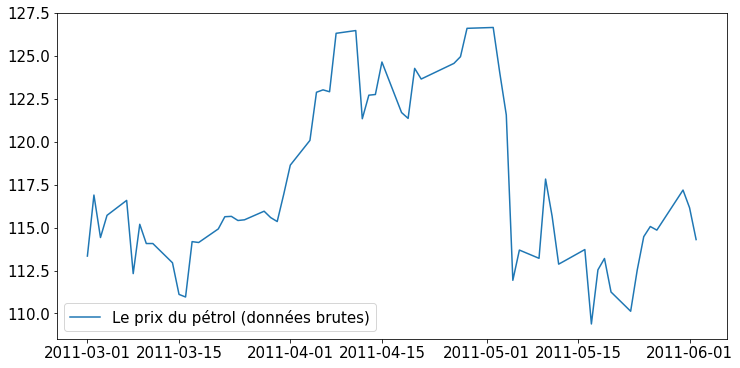

In [132]:
## Il se peut que les variations sur les tweets sont en décalage temporelle avec  
## le prix du pétrole. Autrement dit, la variation entre le prix du pétrole et la réaction 
## des tweeteurs est asynchrone. Nous allons étaler la durée de l'échantillon du prix du pétrole 
## afin d'observer s'il y'a un décalage entre les tweets et le prix du pétrole
time_serie_price_std=data[(data.index>="2011-03-01") & (data.index<= "2011-06-02")]
plt.plot(time_serie_price_std, label="Le prix du pétrol (données brutes)")
plt.legend()
plt.show()

In [133]:
# On normalise la série temporelle. Ces sorties seront entre 0 et 1 afin de comparer la variation de la série du prix 
# avec la variation des sentiments des tweets
def normalize_data(df):
    min = df.min()
    max = df.max()
    x = df    
    y = (x - min) / (max - min)
    
    return y

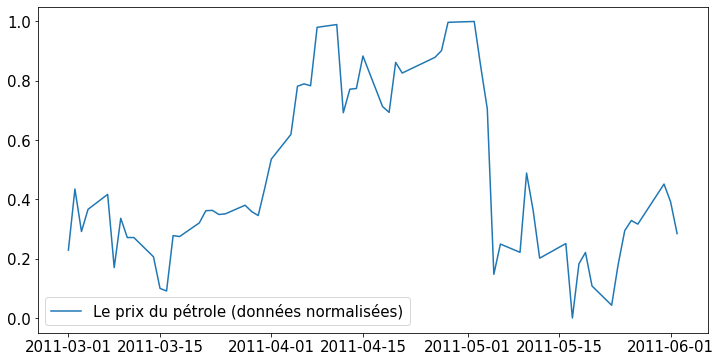

In [134]:
time_serie_price_std= normalize_data(time_serie_price_std)
plt.plot(time_serie_price_std, label="Le prix du pétrole (données normalisées)")
plt.legend()
plt.show()

### 5- Analayse et comparaison des résultats :

<ipython-input-135-4e9e03c8f6ee>:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



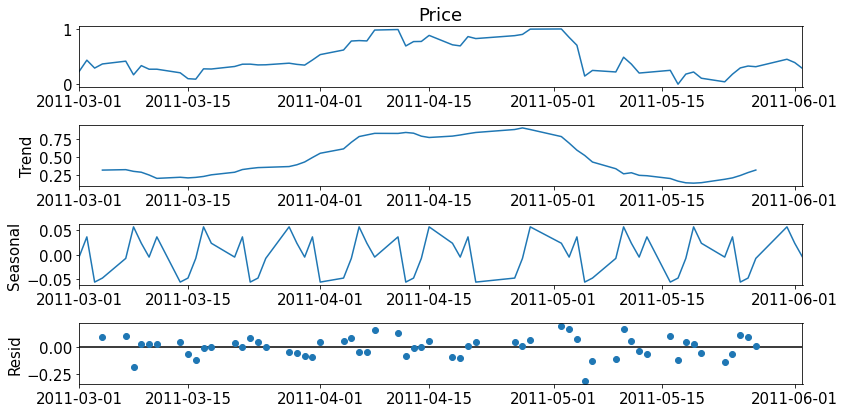

In [135]:
### Au niveau de la tendance du prix du pétrole. On remarque une croissance au niveau de la courbe 
### entre 03-15 et 02-05. Ceci montre que le prix du pétrole augmente par rapport à l'habitude durant cette durée
dec_prix_petrole = seasonal_decompose(time_serie_price_std.Price,model="additive",freq=7)
dec_prix_petrole.plot()
plt.show()

<ipython-input-136-54d8fef3e256>:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



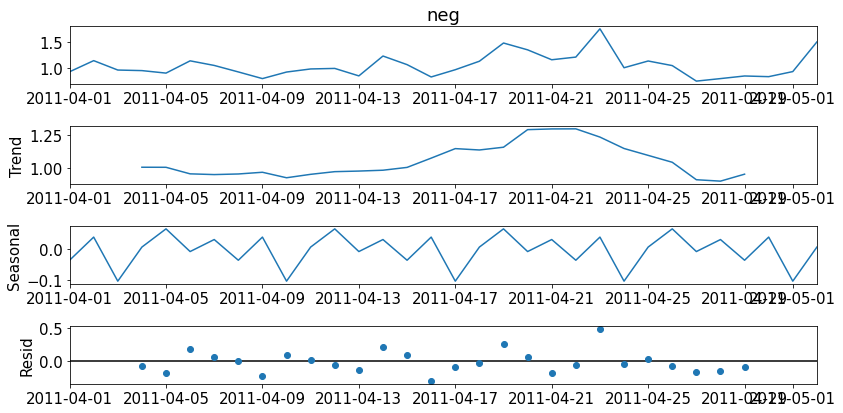

In [136]:
### Au niveau de la tendance, on remarque une croissance du score des tweets negatifs entre 10-04 et le 23-04
### On ajouter *10 afin de comparer les deux courbe sur le meme echelle
tweets_score_neg_analysis = seasonal_decompose(tweets_analysis_per_day.neg*10,model="additive",freq=7)
tweets_score_neg_analysis.plot()
plt.show()

<ipython-input-137-18e8b5128493>:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



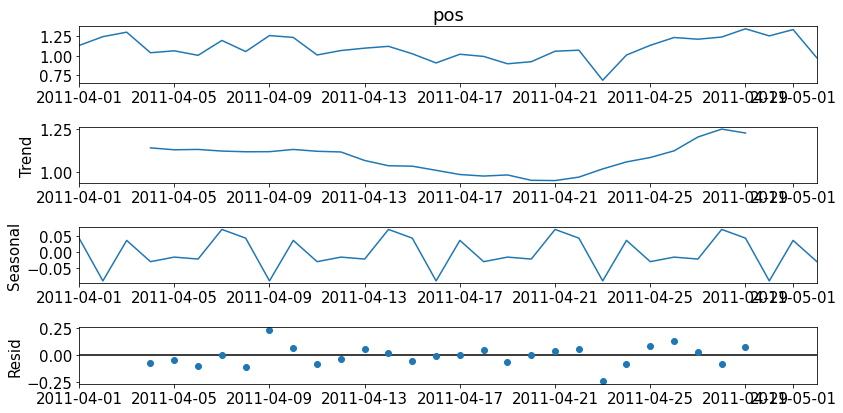

In [137]:
### Au niveau de la tendance des tweets positifs, on remarque une décroissance du score des tweets positifs 
### entre 04-04 et le 20-04
tweets_score_pos_analysis = seasonal_decompose(tweets_analysis_per_day.pos*10,model="additive",freq=7)
tweets_score_pos_analysis.plot()
plt.show()

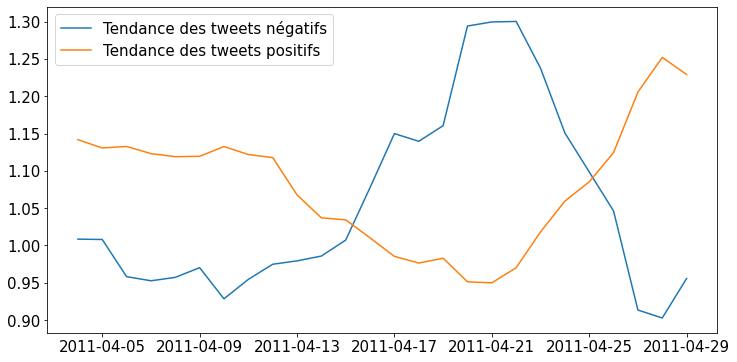

In [138]:
### La tendance des tweets positifs est corrélées inversement avec la tendance des tweets négatifs durant la période 
## de croissance du prix du pétrole. La corrélation de Pearson ne permet pas de données une valeur significative 
## sur la correlation. En effet, les deux séries sont corrélées avec un décalage temporelle
plt.plot(tweets_score_neg_analysis.trend,label="Tendance des tweets négatifs")
plt.plot(tweets_score_pos_analysis.trend,label="Tendance des tweets positifs")
plt.legend()
plt.show()

In [139]:
## On s'interesse plus au comportement des tweets négatifs durant cette analyse 
def visualiser_tendance(df,title):
    fig = px.line(df.trend, x=df.trend.index, y=df.trend.values, title=str(title))
    
    fig.update_xaxes(rangeslider_visible=True)
    return fig.show()

In [140]:
## On remarque que les deux courbes sont corrélées positivement et suivent les meme variations avec un décalage temporaire 
## On remarque que la croissance du prix du pétrole vient en premier par rapport à la croissance des tweets négatifs 
## En effet, le prix du pétrole augmente à partie du 13-03. Cependant, le score des tweets négatifs augmente à partir du 10-04
## d'une part. D'autre part, le prix du pétrole commence à baisser à partir du 26-04 et le score des tweets négatifs 
## a baissé aussi à partir du 22-04. Il est claire que les deux courbes sont corrélées positivement avec un décalage temporelles
## Hypothese : Peut-on conclure une relation de causalité durant la croissance 
## du prix du pétrole (le prix du pétrole => le score des tweets négatifs) ??
## La corrélation n'est pas suffisante pour conclure, nous aurons besoins de certaines regles d'association et de tester
## cette approche sur des différents scénarios
## Le calcul de la corrélation reste difficile vu que la plupart des méthodes de corrélation sont synchrones
## Cependant, pour comparer la variation entre les séries temporelles nous aurons besoin d'une métrique asynchrone 
## comme c'est le cas pour le DTW 
visualiser_tendance(dec_prix_petrole,"La tendance du prix du pétrole")
visualiser_tendance(tweets_score_neg_analysis,"La tendance des tweets négatifs")
# fig = px.line(dec_prix_petrole.trend, x=dec_prix_petrole.trend.index, y=dec_prix_petrole.trend.values, "La tendance du prix du pétrole")   
# fig.update_xaxes(rangeslider_visible=True)



In [141]:
Most_Positive = df[df['pos'].between(0.4,1)]
Most_Negative = df[df['neg'].between(0.25,1)]

(-0.5, 599.5, 399.5, -0.5)

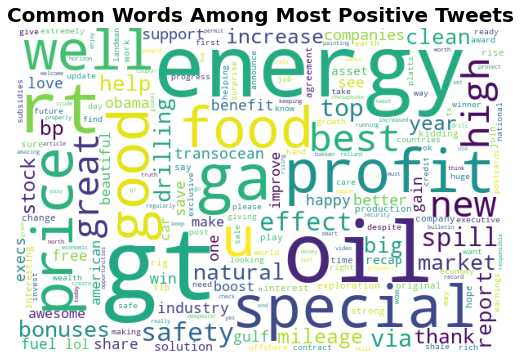

In [142]:

plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
Most_Positive_text = ' '.join(Most_Positive.content)
Most_Negative_text = ' '.join(Most_Negative.content)
pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)
plt.title('Common Words Among Most Positive Tweets',fontsize=20,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

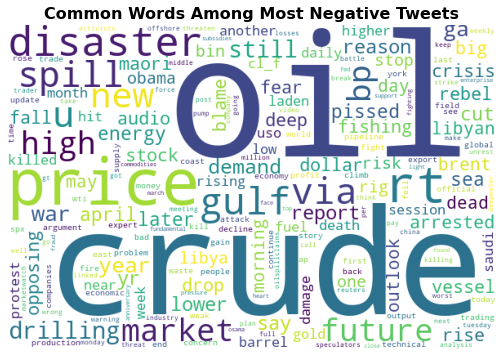

In [143]:
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

In [144]:
## Cette fonction prend le dataframe et le nombre (seuil) des mots les plus répandus
## sur les tweets. 
def top_words(df,Nombre):
    A=pd.DataFrame(pd.Series(' '.join(df['content']).lower().split()).value_counts()[:Nombre])
    A.index.names=["Mot"]
    A=A.rename(columns={0:"Nombre de fois cité sur les tweets"})
    A["Fréquence d'apparition"]=A/A.sum()
    A=A.reset_index()
    print("top "+str(Nombre)+" des mots les plus répandus sur le content des tweets (par ordre décroissant)")
    return A

In [145]:
Nombre =50
top_words(df,Nombre)

top 50 des mots les plus répandus sur le content des tweets (par ordre décroissant)


,Mot,Nombre de fois cité sur les tweets,Fréquence d'apparition
0,oil,8454,0.165172
1,prices,3501,0.068402
2,rt,2215,0.043276
3,crude,2158,0.042162
4,gas,2056,0.040170
5,spill,1839,0.035930
6,us,1767,0.034523
7,2011,1422,0.027783
8,bp,1327,0.025927
9,1,1271,0.024832


### 6- Application sur un autre exemple (cas ou on a une chute du prix):

In [146]:
date_début_serie_prix_petrole="2019-12-31"
date_fin_serie_prix_petrole="2020-06-02"

In [147]:
### Cette fois-ci, on va prendre le min pour l'année 2020
### Pour la série temporelle du prix issue d'une aggrégation par moyenne
### Vous pouvez zoomer sur la partie de la série entre 31-12-2020 et 30-06-2021
### le prix du pétrole a connu une forte baisse entre le 31-12-2020 et le 30-04-2021
data_filt_moyenne=data_monthly[(data_monthly.index>=date_début_serie_prix_petrole) & (data_monthly.index<=date_fin_serie_prix_petrole)]
#data_filt_moyenne_dec=seasonal_decompose(data_filt_moyenne.Price,model="additive",freq=7)
#visualiser_tendance(data_filt_moyenne_dec,"La tendance du prix du pétrole aggrégé par moyenne et par mois")

In [148]:
## Pour la série temporelle du prix issue des données brutes
### Vous pouvez zoomer sur la partie de la série entre 07-01-2020 et 30-06-2021
## le prix du pétrole a connu une forte baisse entre le 31-12-2020 et le 30-04-2021
data_filt_brute=data[(data.index>=date_début_serie_prix_petrole) & (data.index<=date_fin_serie_prix_petrole)]
data_filt_brute_dec=seasonal_decompose(data_filt_brute.Price,model="additive",freq=7)
visualiser_tendance(data_filt_brute_dec,"La tendance du prix du pétrole des données brutes par jour")

<ipython-input-148-68c1a9d2858a>:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



In [149]:
#### On réalise l'extraction des données tweets 
tweets_2020=pd.read_csv("/Users/mahsamaali/Downloads/data_tweets_2020 - 2020-04-02.csv") 
tweets_2020.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.



,date,content,user,replyCount,retweetCount,likeCount,quoteCount,retweetedTweet,quotedTweet,inReplyToTweetId,hashtags,cashtags
0,2020-04-01 23:57:42+00:00,"Thirteen permits renewed, including nine CLR J...","{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,1.0,0.0,0.0,NaN,NaN,NaN,"['Bakken', 'NorthDakota', 'OOTT']",NaN
1,2020-04-01 23:57:05+00:00,How Low Could U.S. Oil Production Actually Go?...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,['oilprice'],NaN
2,2020-04-01 23:51:51+00:00,State giant Aramco offering 18.8 million barre...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,2.0,0.0,NaN,NaN,NaN,"['FMTNews', 'Oil', 'Opec', 'Aramco', 'Saudi']",NaN
3,2020-04-01 23:51:11+00:00,Still more land being acquired around $TVE.TO ...,"{'_type': 'snscrape.modules.twitter.User', 'us...",2.0,1.0,6.0,1.0,NaN,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,['OOTT'],"['TVE.TO', 'TOG.TO']"
4,2020-04-01 23:50:07+00:00,We offer price risk management for a variety o...,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,1.0,0.0,NaN,NaN,NaN,"['grains', 'dairy', 'wheat', 'corn', 'cattle',...",NaN


In [150]:
#### Compression du code (on refait les étapes appliqués auparavant sur le premier exemple)

La fréquence des valeurs nulles pour chaque colonne (par ordre décroissant) :
retweetedTweet      100.000000
cashtags             91.712516
inReplyToTweetId     91.426117
quotedTweet          90.078534
hashtags              0.301473
quoteCount            0.021103
likeCount             0.015074
retweetCount          0.015074
replyCount            0.015074
user                  0.015074
content               0.009044
date                  0.006029
dtype: float64
------------------------------------------------------------------------------------
Taille de données brutes (lignes, colonnes) : (66341, 12)
------------------------------------------------------------------------------------
Traitement et conversion en cours ... 


<ipython-input-151-6e4250039d55>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-------------------------------------------------------------------------------------
L'analyse des sentiments des tweets est en cours ...
-------------------------------------------------------------------------------------
Taille de données brutes après traitement(lignes, colonnes) : (66336, 11)
-------------------------------------------------------------------------------------
Traitement, conversion, cleaning du content, analyse des sentiments des tweeets sont terminés
Vos données sont pretes à utiliser
-------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------


<ipython-input-151-6e4250039d55>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



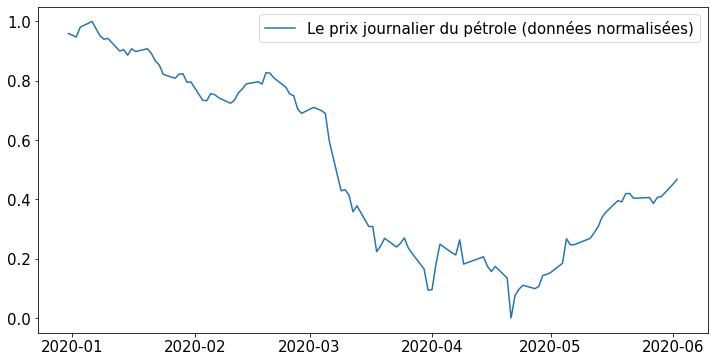

<ipython-input-151-6e4250039d55>:35: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



--------------------------------------------------------------------------------------------------
Décomposition de la série du score positif des tweets


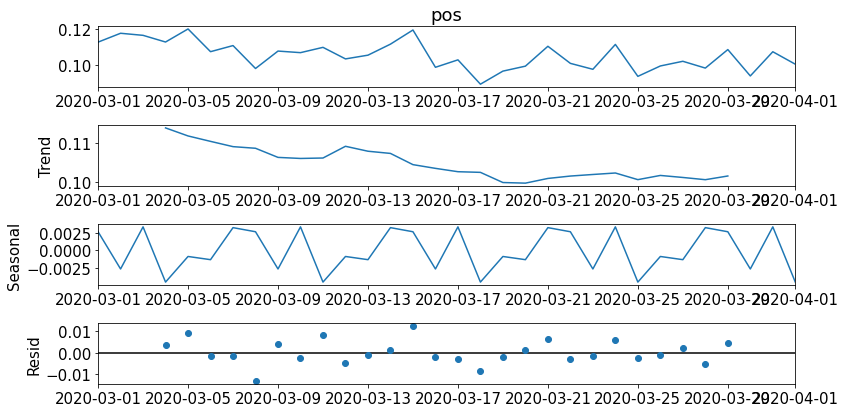

--------------------------------------------------------------------------------------------------
Décomposition de la série du score négatif des tweets


<ipython-input-151-6e4250039d55>:40: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



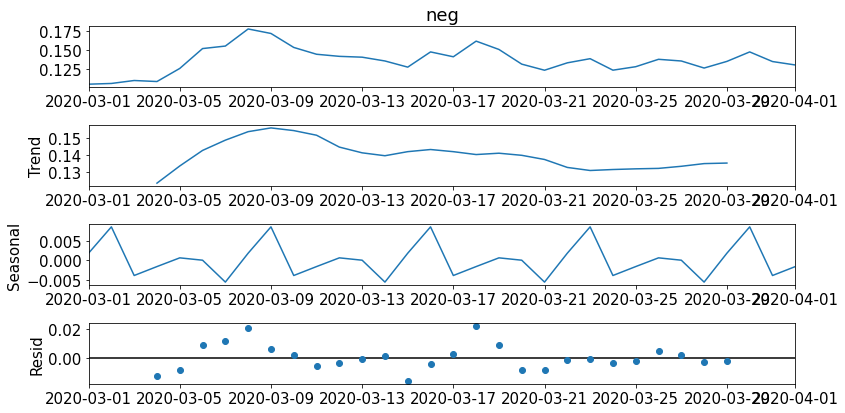

--------------------------------------------------------------------------------------------------
Comparaison de la tendance des scores des tweets


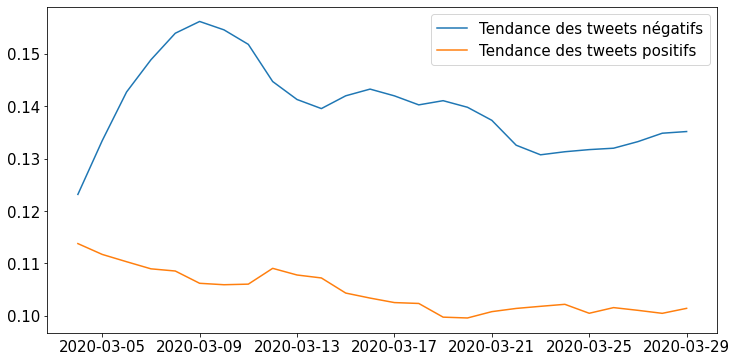

--------------------------------------------------------------------------------------------------


<ipython-input-151-6e4250039d55>:51: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



In [151]:
print("La fréquence des valeurs nulles pour chaque colonne (par ordre décroissant) :")
print(((tweets_2020.isnull().sum()/tweets_2020.shape[0])*100).sort_values(ascending=False))
print("------------------------------------------------------------------------------------")
print("Taille de données brutes (lignes, colonnes) :", tweets_2020.shape)
print("------------------------------------------------------------------------------------")
print("Traitement et conversion en cours ... ")
df_2020=tweets_2020[["date","content","user","replyCount","retweetCount","likeCount","quoteCount","hashtags"]]
df_2020["date"]=pd.to_datetime(df_2020["date"], errors ='coerce')
df_2020=df_2020.drop_duplicates()
df_2020=df_2020.drop(df.index[df.isnull().any(axis=1)])
df_2020=df_2020.fillna(0)
df_2020=df_2020.reset_index(drop=True)
df_2020=cleaning_content(df_2020)
print("-------------------------------------------------------------------------------------")
print("L'analyse des sentiments des tweets est en cours ...")
df_2020=sentiment_analysis_score(df_2020)
print("-------------------------------------------------------------------------------------")
print("Taille de données brutes après traitement(lignes, colonnes) :", df_2020.shape)
print("-------------------------------------------------------------------------------------")
print("Traitement, conversion, cleaning du content, analyse des sentiments des tweeets sont terminés")
print("Vos données sont pretes à utiliser")
print("-------------------------------------------------------------------------------------")
tweets_analysis_per_day=df_2020[["date","pos","neg","neu"]]
tweets_analysis_per_day["date"]=pd.to_datetime(tweets_analysis_per_day["date"], errors ='coerce',utc=True)
tweets_analysis_per_day=tweets_analysis_per_day.set_index(['date'])
tweets_analysis_per_day=tweets_analysis_per_day.resample("D").mean()
time_serie_price_std=data[(data.index>=date_début_serie_prix_petrole) & (data.index<= date_fin_serie_prix_petrole)]
print("--------------------------------------------------------------------------------------------------")
time_serie_price_std= normalize_data(time_serie_price_std)
plt.plot(time_serie_price_std, label="Le prix journalier du pétrole (données normalisées)")
plt.legend()
plt.show()
print("--------------------------------------------------------------------------------------------------")
print("Décomposition de la série du score positif des tweets")
tweets_score_pos_analysis = seasonal_decompose(tweets_analysis_per_day.pos,model="additive",freq=7)
tweets_score_pos_analysis.plot()
plt.show()
print("--------------------------------------------------------------------------------------------------")
print("Décomposition de la série du score négatif des tweets")
tweets_score_neg_analysis = seasonal_decompose(tweets_analysis_per_day.neg,model="additive",freq=7)
tweets_score_neg_analysis.plot()
plt.show()
plt.show()
print("--------------------------------------------------------------------------------------------------")
print("Comparaison de la tendance des scores des tweets")
plt.plot(tweets_score_neg_analysis.trend,label="Tendance des tweets négatifs")
plt.plot(tweets_score_pos_analysis.trend,label="Tendance des tweets positifs")
plt.legend()
plt.show()
print("--------------------------------------------------------------------------------------------------")
dec_prix_petrole = seasonal_decompose(time_serie_price_std.Price,model="additive",freq=7)
visualiser_tendance(dec_prix_petrole,"La tendance du prix du pétrole")
visualiser_tendance(tweets_score_pos_analysis,"La tendance des tweets postifs")
visualiser_tendance(tweets_score_neg_analysis,"La tendance des tweets neg")

(-0.5, 599.5, 399.5, -0.5)

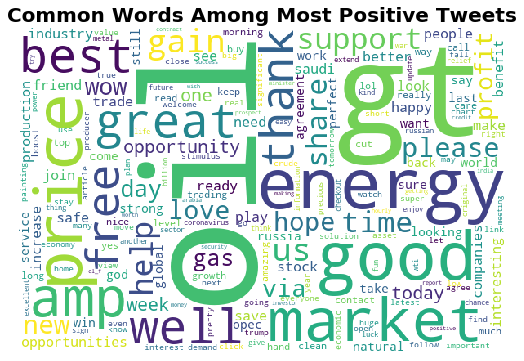

In [123]:
Most_Positive = df_2020[df_2020['pos'].between(0.4,1)]
Most_Negative = df_2020[df_2020['neg'].between(0.25,1)]
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
Most_Positive_text = ' '.join(Most_Positive.content)
Most_Negative_text = ' '.join(Most_Negative.content)
pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)
plt.title('Common Words Among Most Positive Tweets',fontsize=20,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')

---------------------------------------------------------------------------------------


(-0.5, 599.5, 399.5, -0.5)

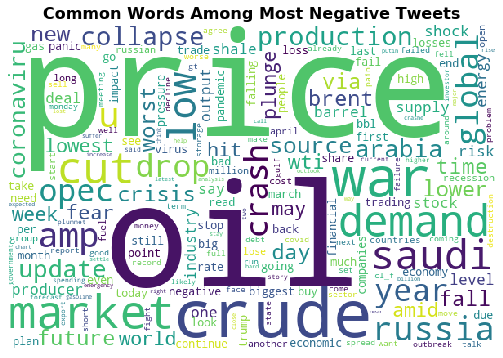

In [124]:
print("---------------------------------------------------------------------------------------")
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

In [125]:
print("-----------------------------------------------------------------------------------------")
top_words(df_2020,Nombre)

-----------------------------------------------------------------------------------------
top 50 des mots les plus répandus sur le content des tweets (par ordre décroissant)


,Mot,Nombre de fois cité sur les tweets,Fréquence d'apparition
0,oil,21667,0.136080
1,price,8305,0.052160
2,prices,7586,0.047644
3,crude,6344,0.039844
4,amp,5473,0.034373
5,us,5114,0.032119
6,market,4820,0.030272
7,1,4454,0.027974
8,saudi,3921,0.024626
9,war,3690,0.023175


In [126]:
#### Dans notre deuxieme exemple, on remarque que les variations des tweets positifs sont corrélées avec les variations
#### de la baisse du prix du pétrole. Ceci montre que les gens ne sont pas satisfaits de cette baisse du prix.
#### D'apres nos recherches, le prix du pétrole a connu une forte baisse
#### après la propagation du virus. Bien que le mot coronavirus n'était pas 
#### la tendance durant le début du 2020, il classé à la 40eme position apres Guerre, Russia, US et Saudi 
#### les grands fournisseurs du pétrole

# Pie chart 

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

def percentage(part,whole):
 return 100 * float(part)/float(whole)

tweets=data['content'].values.tolist()

print("len of tweets",len(tweets))

for tweet in tweets:

	# print(tweet.text)
	tweet_list.append(tweet)

	analysis = TextBlob(tweet)
	score = SentimentIntensityAnalyzer().polarity_scores(tweet)
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']
	polarity += analysis.sentiment.polarity

	if neg > pos:
		negative_list.append(tweet)
		negative += 1
	elif pos > neg:
		positive_list.append(tweet)
		positive += 1

	elif pos == neg:
		neutral_list.append(tweet)
		neutral += 1

noOfTweet=len(tweets)
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)



tw_list = pd.DataFrame(tweet_list)
tw_list["content"] = tw_list[0]


#Sentiment Analyse
#
tw_list[['polarity', 'subjectivity']] = tw_list['content'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['content'].iteritems():
	score = SentimentIntensityAnalyzer().polarity_scores(row)
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']
	if neg > pos:
		tw_list.loc[index, 'sentiment'] = "negative"
	elif pos > neg:
		tw_list.loc[index, 'sentiment'] = "positive"
	else:
		tw_list.loc[index, 'sentiment'] = "neutral"
		tw_list.loc[index, 'neg'] = neg
		tw_list.loc[index, 'neu'] = neu
		tw_list.loc[index, 'pos'] = pos
		tw_list.loc[index, 'compound'] = comp





#Creating PieCart -Viz
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use("default")
plt.legend(labels)
plt.axis("equal")
plt.show()